In [3]:
!pip install imutils

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [5]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

print("[INFO] loading images...")
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

[INFO] loading images...


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [8]:
labels

array(['without_mask', 'without_mask', 'without_mask', ..., 'with_mask',
       'with_mask', 'with_mask'], dtype='<U12')

In [9]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [11]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [12]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [ ]:
import gc
del(data)
del(labels)
gc.collect()

In [16]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [17]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [18]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [19]:
for layer in baseModel.layers:
    layer.trainable = False

In [21]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [22]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS
)

Epoch 1/20
102/102 [==============================] - 65s 619ms/step - loss: 0.4034 - accuracy: 0.8608 - val_loss: 0.1402 - val_accuracy: 0.9805
Epoch 2/20
102/102 [==============================] - 64s 624ms/step - loss: 0.1442 - accuracy: 0.9673 - val_loss: 0.0780 - val_accuracy: 0.9841
Epoch 3/20
102/102 [==============================] - 65s 633ms/step - loss: 0.1010 - accuracy: 0.9766 - val_loss: 0.0632 - val_accuracy: 0.9866
Epoch 4/20
102/102 [==============================] - 65s 638ms/step - loss: 0.0783 - accuracy: 0.9769 - val_loss: 0.0540 - val_accuracy: 0.9878
Epoch 5/20
102/102 [==============================] - 68s 667ms/step - loss: 0.0665 - accuracy: 0.9833 - val_loss: 0.0491 - val_accuracy: 0.9866
Epoch 6/20
102/102 [==============================] - 77s 754ms/step - loss: 0.0563 - accuracy: 0.9830 - val_loss: 0.0468 - val_accuracy: 0.9866
Epoch 7/20
102/102 [==============================] - 85s 832ms/step - loss: 0.0545 - accuracy: 0.9852 - val_loss: 0.0450 - val_ac

In [23]:
model.save('trained_model.h5', save_format="h5")

In [1]:
# ----------------------------------------------- Restart The Kernel

In [2]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import os

In [3]:
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join(['face_detector', "deploy.prototxt"])
weightsPath = os.path.sep.join(['face_detector', "res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)
model = load_model('trained_model.h5')
image = cv2.imread('dataset/with_mask/0999.png')
orig = image.copy()
(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

[INFO] loading face detector model...
[INFO] computing face detections...


In [4]:
for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.6:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
        (mask, withoutMask) = model.predict(face)[0]
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
        cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)


1/1 [==============================] - 0s 26ms/step


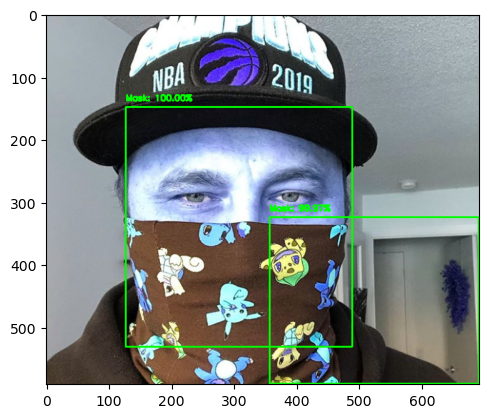

In [6]:
from matplotlib import pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
plt.imshow(image)
plt.show()

In [24]:
# MasoudKaviani.ir